In [14]:
import numpy as np
import pandas as pd

In [15]:
location_info = {
    "washingtondc": {
        "station_id": "USW00013743",
        "lat": 38.8853,
        "long": -77.0386,
        "alt": 0,
        "bloom_csv": "washingtondc.csv"
    },
    "vancouver": {
        "station_id": "CA001108395",
        "lat": 49.2463,
        "long": -123.1162,
        "alt": 24,
        "bloom_csv": "vancouver.csv"
    },
    "newyorkcity": {
        "station_id": "USW00014732",
        "lat": 40.7304,
        "long": -74.0000,
        "alt": 8.5,
        "bloom_csv": "nyc.csv"
    },
    "liestal": {
        "station_id": "SZ000001940",
        "lat": 47.4814,
        "long": 7.7305,
        "alt": 350,
        "bloom_csv": "liestal.csv"
    },
    "kyoto": {
        "station_id": "JA000047759",
        "lat": 35.0119831,
        "long": 135.6761135,
        "alt": 44,
        "bloom_csv": "kyoto.csv"
    }
}

In [16]:
import pandas as pd
import numpy as np

def compute_features(df_raw, Tbase=5.0):
    """
    针对整张表 df_raw（含多地点/多年份），
    逐个 (lat, long, year) 分组，计算所需的气象特征：
      - TAVG      = (TMAX + TMIN)/2  (若已有则可跳过)
      - GDD       = max(0, TAVG - Tbase)
      - GDD_cumsum
      - TAVG_7d   : 7天滚动均值
      - PRCP_7d_cumsum : 7天滚动降水
      - Tmax_Winter, Tmin_Winter    : 当年冬季(12/1~2/28)的全季最高/最低温
    并返回含 FEATURE_COLS 的新 DataFrame
    """
    df = df_raw.copy()

    # 1) 确保 DATE 为日期类型，方便排序
    df["DATE"] = pd.to_datetime(df["DATE"])
    # 补充一个日序 DOY，可能后面要用
    df["DOY"] = df["DATE"].dt.dayofyear

    # 2) 如果没有 TAVG，则自行计算
    if "TAVG" not in df.columns:
        df["TAVG"] = (df["TMAX"] + df["TMIN"]) / 2

    # 3) 按 (lat, long, year) 分组，分别处理
    results = []
    group_cols = ["lat", "long", "year"]
    for (la, lo, yr), grp in df.groupby(group_cols):
        grp = grp.sort_values("DATE").copy()

        # （可选）检查日期是否每天都有：如果需要“每天不缺失”，可以 reindex 到完整日期再插值
        # 这里演示最简化：只要数据不缺就直接计算

        # 计算 GDD
        grp["GDD"] = (grp["TAVG"] - Tbase).clip(lower=0)
        grp["GDD_cumsum"] = grp["GDD"].cumsum()

        # 7日滚动均值、累积
        grp["TAVG_7d"] = grp["TAVG"].rolling(window=7, min_periods=1).mean()
        grp["PRCP_7d_cumsum"] = grp["PRCP"].rolling(window=7, min_periods=1).sum()

        # 标记季节 (简单区分)
        def get_season(dt):
            m = dt.month
            if m in [12, 1, 2]:
                return "Winter"
            elif m in [3, 4, 5]:
                return "Spring"
            elif m in [6, 7, 8]:
                return "Summer"
            else:
                return "Fall"
        grp["Season"] = grp["DATE"].apply(get_season)

        # 先创建列，默认 NaN
        grp["Tmax_Winter"] = np.nan
        grp["Tmin_Winter"] = np.nan

        # 在冬季行上赋值 TMAX/TMIN，用于后续 groupby transform
        winter_mask = (grp["Season"] == "Winter")
        grp.loc[winter_mask, "Tmax_Winter"] = grp.loc[winter_mask, "TMAX"]
        grp.loc[winter_mask, "Tmin_Winter"] = grp.loc[winter_mask, "TMIN"]

        # 整个冬季的最高/最低温（同一个 year 内）
        # 注：若要跨年（12月算到下一年冬季）需做额外的 winter_year 处理
        grp["Tmax_Winter"] = grp.groupby(group_cols)["Tmax_Winter"].transform("max")
        grp["Tmin_Winter"] = grp.groupby(group_cols)["Tmin_Winter"].transform("min")

        results.append(grp)

    df_out = pd.concat(results, ignore_index=True)
    return df_out


# =========== 示例：读取 CSV，计算特征 ===========
df_new = pd.read_csv("qyx_final_data_1.csv")

# 计算特征
df_featured = compute_features(df_new, Tbase=5.0)


In [17]:
df_featured

,lat,long,bloom_doy,year,alt,DATE,TMAX,TMIN,PRCP,DOY,TAVG,GDD,GDD_cumsum,TAVG_7d,PRCP_7d_cumsum,Season,Tmax_Winter,Tmin_Winter
0,24.336667,124.164444,39.0,2021,5.7,2021-02-22,2.270000,1.800000,0.0,53,2.035000,0.0,0.0,2.035000,0.0,Winter,3.0025,1.4
1,24.336667,124.164444,39.0,2021,5.7,2021-02-23,2.265833,1.818333,0.0,54,2.042083,0.0,0.0,2.038542,0.0,Winter,3.0025,1.4
2,24.336667,124.164444,39.0,2021,5.7,2021-02-24,2.261667,1.800000,0.0,55,2.030833,0.0,0.0,2.035972,0.0,Winter,3.0025,1.4
3,24.336667,124.164444,39.0,2021,5.7,2021-02-25,2.257500,1.810000,0.0,56,2.033750,0.0,0.0,2.035417,0.0,Winter,3.0025,1.4
4,24.336667,124.164444,39.0,2021,5.7,2021-02-26,2.253333,1.806667,0.0,57,2.030000,0.0,0.0,2.034333,0.0,Winter,3.0025,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166630,47.481400,7.730519,80.0,2024,350.0,2024-12-27,0.000000,0.000000,0.0,362,0.000000,0.0,0.0,0.007143,218.0,Winter,0.1000,0.0
166631,47.481400,7.730519,80.0,2024,350.0,2024-12-28,0.000000,0.000000,0.0,363,0.000000,0.0,0.0,0.007143,184.0,Winter,0.1000,0.0
166632,47.481400,7.730519,80.0,2024,350.0,2024-12-29,0.000000,0.000000,0.0,364,0.000000,0.0,0.0,0.000000,34.0,Winter,0.1000,0.0
166633,47.481400,7.730519,80.0,2024,350.0,2024-12-30,0.000000,0.000000,0.0,365,0.000000,0.0,0.0,0.000000,0.0,Winter,0.1000,0.0


In [18]:
df_featured=df_featured[(df_featured['DOY']>=35) & (df_featured['DOY']<=95)]
df_featured

,lat,long,bloom_doy,year,alt,DATE,TMAX,TMIN,PRCP,DOY,TAVG,GDD,GDD_cumsum,TAVG_7d,PRCP_7d_cumsum,Season,Tmax_Winter,Tmin_Winter
0,24.336667,124.164444,39.0,2021,5.7,2021-02-22,2.270000,1.800000,0.0,53,2.035000,0.0,0.0,2.035000,0.0,Winter,3.0025,1.4
1,24.336667,124.164444,39.0,2021,5.7,2021-02-23,2.265833,1.818333,0.0,54,2.042083,0.0,0.0,2.038542,0.0,Winter,3.0025,1.4
2,24.336667,124.164444,39.0,2021,5.7,2021-02-24,2.261667,1.800000,0.0,55,2.030833,0.0,0.0,2.035972,0.0,Winter,3.0025,1.4
3,24.336667,124.164444,39.0,2021,5.7,2021-02-25,2.257500,1.810000,0.0,56,2.033750,0.0,0.0,2.035417,0.0,Winter,3.0025,1.4
4,24.336667,124.164444,39.0,2021,5.7,2021-02-26,2.253333,1.806667,0.0,57,2.030000,0.0,0.0,2.034333,0.0,Winter,3.0025,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166359,47.481400,7.730519,80.0,2024,350.0,2024-03-31,0.100000,0.000000,52.0,91,0.050000,0.0,0.0,0.050000,99.0,Spring,0.1000,0.0
166360,47.481400,7.730519,80.0,2024,350.0,2024-04-01,0.100000,0.000000,6.0,92,0.050000,0.0,0.0,0.050000,105.0,Spring,0.1000,0.0
166361,47.481400,7.730519,80.0,2024,350.0,2024-04-02,0.100000,0.000000,1.0,93,0.050000,0.0,0.0,0.050000,106.0,Spring,0.1000,0.0
166362,47.481400,7.730519,80.0,2024,350.0,2024-04-03,0.100000,0.000000,19.0,94,0.050000,0.0,0.0,0.050000,124.0,Spring,0.1000,0.0


In [19]:
def create_sliding_window_samples(df_weather_all, feature_cols, window_size, max_label):
    """
    df_weather_all: 包含多地点多年份的气象数据, 每行有 [lat, long, year, DOY, bloom_doy, ...]
    feature_cols : 特征列列表
    window_size  : 滑窗长度 (10 天)
    max_label    : 超过这个天数就截断为 max_label
    """
    X_list = []
    y_list = []

    # 改成 groupby (lat, long, year)
    grouped = df_weather_all.groupby(["lat", "long", "year"])

    for (la, lo, yr), sub_weather in grouped:
        sub_weather = sub_weather.sort_values("DATE").copy()

        # 1) 检查是否有 bloom_doy
        if sub_weather["bloom_doy"].isna().all():
            continue  # 没有开花日期就无法做监督

        # 2) 检查是否连续
        #   如果任何相邻两天的 DOY 相差 >1，就跳过
        doys = sub_weather["DOY"].values
        day_diff = np.diff(doys)
        if np.any(day_diff > 1):
            # 存在缺口 => 放弃这组数据
            continue

        # 3) 如果行数都 < window_size, 也跳过
        if len(sub_weather) < window_size:
            continue

        # 4) bloom_doy 取该年(该地)第一行的 bloom_doy（或平均）,
        #    也可取 sub_weather["bloom_doy"].dropna().iloc[0]
        bloom_day = sub_weather["bloom_doy"].iloc[0]

        # 5) 准备数组 => shape=(N, F)
        arr_weather = sub_weather[feature_cols].values
        arr_doy = sub_weather["DOY"].values
        N = len(sub_weather)

        # 6) 滑窗遍历
        for i in range(N):
            if i < window_size - 1:
                continue

            current_doy = arr_doy[i]
            seq_data = arr_weather[i - window_size + 1 : i + 1]  # => (window_size, F)

            diff = bloom_day - current_doy
            if diff < 0:
                label = 0
            elif diff > max_label:
                label = max_label
            else:
                label = diff

            X_list.append(seq_data)
            y_list.append(label)

    X_arr = np.array(X_list, dtype=np.float32)  # (samples, window_size, F)
    y_arr = np.array(y_list, dtype=np.int32)

    # （可选）如果要过滤 label=0
    mask = y_arr > 0
    X_arr = X_arr[mask]
    y_arr = y_arr[mask]

    return X_arr, y_arr


# =========== 使用示例 ===========

FEATURE_COLS = [
    "GDD_cumsum", "TMAX", "TMIN", "TAVG", "PRCP",
    "Tmax_Winter", "Tmin_Winter", "GDD",
    "TAVG_7d", "PRCP_7d_cumsum", "lat", "long", "alt"
]

WINDOW_SIZE = 10
MAX_LABEL = 60

# 在前面已经得到 df_featured，包含 bloom_doy, lat, long, year, DOY, 以及各项气象特征
X, y = create_sliding_window_samples(
    df_weather_all = df_featured,   # 这就是上一步计算好特征的数据
    feature_cols   = FEATURE_COLS,
    window_size    = WINDOW_SIZE,
    max_label      = MAX_LABEL
)
print("X.shape =", X.shape)
print("y.shape =", y.shape)


X.shape = (19818, 10, 13)
y.shape = (19818,)


In [20]:
df=pd.DataFrame({'X':X.tolist(),'y':y.tolist()})
df

,X,y
0,"[[0.0, 2.200000047683716, 0.8999999761581421, ...",5
1,"[[0.0, 2.299999952316284, 1.7858333587646484, ...",4
2,"[[0.0, 2.200000047683716, 1.7725000381469727, ...",3
3,"[[0.0, 2.299999952316284, 1.2999999523162842, ...",2
4,"[[0.0, 2.299999952316284, 1.755833387374878, 2...",1
...,...,...
19813,"[[0.0, 0.0, 0.0, 0.0, 75.0, 0.1000000014901161...",5
19814,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000149011612...",4
19815,"[[0.0, 0.10000000149011612, 0.0, 0.05000000074...",3
19816,"[[0.0, 0.10000000149011612, 0.0, 0.05000000074...",2


Epoch 1/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.0309 - loss: 4.1045 - val_accuracy: 0.0767 - val_loss: 4.0524
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0839 - loss: 4.0155 - val_accuracy: 0.0764 - val_loss: 3.9638
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0820 - loss: 3.9403 - val_accuracy: 0.0769 - val_loss: 3.9200
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0850 - loss: 3.8937 - val_accuracy: 0.0759 - val_loss: 3.8868
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0847 - loss: 3.8571 - val_accuracy: 0.0772 - val_loss: 3.8542
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0835 - loss: 3.8331 - val_accuracy: 0.0800 - val_loss: 3.8241
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0873 - loss: 3.7980 - val_accuracy: 0.0772 - val_loss: 3.7961
Epoch 8/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0867 - loss: 3.7866 - val_accuracy: 

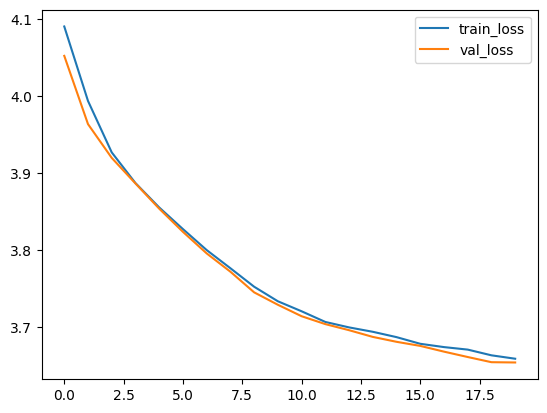

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0826 - loss: 3.6699
Test accuracy: 0.08728557080030441
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test R² = 0.09017468908485171


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化
N_tr, T, F = X_train.shape
N_te = X_test.shape[0]

X_train_2d = X_train.reshape(N_tr*T, F)
X_test_2d  = X_test.reshape(N_te*T, F)

X_train_2d = np.nan_to_num(X_train_2d, nan=0.0)
X_test_2d  = np.nan_to_num(X_test_2d,  nan=0.0)

scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_test_scaled_2d  = scaler.transform(X_test_2d)

X_train_scaled = X_train_scaled_2d.reshape(N_tr, T, F)
X_test_scaled  = X_test_scaled_2d.reshape(N_te, T, F)

num_classes = MAX_LABEL + 1

model = Sequential()
model.add(LSTM(32, return_sequences=True, activation="tanh", input_shape=(T, F)))
model.add(Dropout(0.2))
model.add(LSTM(16, activation="tanh", return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=32
)

# 可视化
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Test accuracy:", test_acc)

# R²
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
r2 = r2_score(y_test, y_test_pred)
print("Test R² =", r2)


In [22]:
# Prediction for 2025
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Get Data
def fetch_noaa_data(station_id, start_date="2025-01-01", end_date="2025-02-21"):
    """
    从 NOAA NCEI 下载指定站点的日气象数据 (DATE,TMAX,TMIN,PRCP,TAVG) 返回 DataFrame。
    NOAA 可能使用华氏度，需要手动转换为摄氏度。
    """
    base_url = "https://www.ncei.noaa.gov/access/services/data/v1"
    params = {
        "dataset": "daily-summaries",
        "stations": station_id,
        "startDate": start_date,
        "endDate": end_date,
        "format": "json",
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)

        keep_cols = ["DATE","TMAX","TMIN","PRCP","TAVG"]
        for col in keep_cols:
            if col not in df.columns:
                df[col] = np.nan
        df = df[keep_cols]

        for c in ["TMAX","TMIN","PRCP","TAVG"]:
            df[c] = pd.to_numeric(df[c], errors="coerce")

        df["DATE"] = pd.to_datetime(df["DATE"])
        df.dropna(subset=["DATE"], inplace=True)

        df.sort_values("DATE", inplace=True)
        df.reset_index(drop=True, inplace=True)

        return df
    else:
        print(f"[Error] 请求失败, status_code={response.status_code}")
        return pd.DataFrame(columns=["DATE","TMAX","TMIN","PRCP","TAVG"])

# 3) Processing
def process_weather_df(df_weather, lat, long, alt, Tbase=5.0):

    df = df_weather.copy()


    df.set_index("DATE", inplace=True)
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

    df = df.reindex(full_date_range)
    df.index.name = "DATE"


    numeric_cols = ["TMAX","TMIN","TAVG","PRCP"]
    for c in numeric_cols:
        if c not in df.columns:
            df[c] = np.nan
    # Linear interpolate
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

    df["TMAX"] = df["TMAX"]/ 10
    df["TMIN"] = df["TMIN"]/ 10
    df["TAVG"] = df["TAVG"]/ 10


    df["GDD"] = (df['TAVG'] - Tbase).clip(lower=0)
    df["GDD_cumsum"] = df["GDD"].cumsum()

    df["TAVG_7d"] = df["TAVG"].rolling(window=7, min_periods=1).mean()
    df["PRCP_7d_cumsum"] = df["PRCP"].rolling(window=7, min_periods=1).sum()

    def get_season(d):
        m = d.month
        if m in [12, 1, 2]:
            return "Winter"
        elif m in [3, 4, 5]:
            return "Spring"
        elif m in [6, 7, 8]:
            return "Summer"
        else:
            return "Fall"
    df["Season"] = df.index.map(get_season)

    df["Tmax_Winter"] = np.where(df["Season"]=="Winter", df["TMAX"], np.nan)
    df["Tmin_Winter"] = np.where(df["Season"]=="Winter", df["TMIN"], np.nan)

    df.reset_index(inplace=True)
    df.rename(columns={"DATE":"DATE"}, inplace=True)
    df["lat"] = lat
    df["long"] = long
    df["alt"] = alt

    df["year"] = df["DATE"].dt.year
    df["DOY"]  = df["DATE"].dt.dayofyear

    return df

def predict_days_to_bloom(model, scaler, recent_weather, feature_cols, window_size):
    """
    根据给定的天气特征 recent_weather (形状 window_size x len(feature_cols)) 进行预测。
    """
    arr_2d = recent_weather.reshape(-1, len(feature_cols))  # => (window_size, n_features)
    arr_2d_scaled = scaler.transform(arr_2d)
    arr_3d = arr_2d_scaled.reshape(1, window_size, len(feature_cols))

    prob = model.predict(arr_3d)[0]
    days_left = np.argmax(prob)
    return days_left


FEATURE_COLS = [
    "GDD_cumsum", "TMAX", "TMIN", "TAVG", "PRCP",
    "Tmax_Winter", "Tmin_Winter",
    "GDD", "TAVG_7d", "PRCP_7d_cumsum",
    "lat", "long", "alt"
]
WINDOW_SIZE = 10

# 5) Main
all_processed = []
for loc_name, loc_info in location_info.items():
    print("============================================================")
    print(f"[{loc_name}] Fetching NOAA data...")

    raw_df = fetch_noaa_data(
        station_id=loc_info["station_id"],
        start_date="2025-01-01",
        end_date="2025-02-28",
    )
    if raw_df.empty:
        print(f"[{loc_name}] NOAA data is null")
        continue

    df_weather_new = process_weather_df(
        raw_df,
        lat=loc_info["lat"],
        long=loc_info["long"],
        alt=loc_info["alt"],
        Tbase=5.0
    )
    df_weather_new["location"] = loc_name
    all_processed.append(df_weather_new)

df_weather_all_new = pd.concat(all_processed, ignore_index=True)
df_weather_all_new

[washingtondc] Fetching NOAA data...
[vancouver] Fetching NOAA data...
[newyorkcity] Fetching NOAA data...
[liestal] Fetching NOAA data...
[kyoto] Fetching NOAA data...


,DATE,TMAX,TMIN,PRCP,TAVG,GDD,GDD_cumsum,TAVG_7d,PRCP_7d_cumsum,Season,Tmax_Winter,Tmin_Winter,lat,long,alt,year,DOY,location
0,2025-01-01,11.1,4.40,0.0,9.3,4.3,4.3,9.300000,0.0,Winter,11.1,4.40,38.885300,-77.038600,0.0,2025,1,washingtondc
1,2025-01-02,7.2,2.80,0.0,4.9,0.0,4.3,7.100000,0.0,Winter,7.2,2.80,38.885300,-77.038600,0.0,2025,2,washingtondc
2,2025-01-03,7.8,-0.50,10.0,3.1,0.0,4.3,5.766667,10.0,Winter,7.8,-0.50,38.885300,-77.038600,0.0,2025,3,washingtondc
3,2025-01-04,1.1,-3.20,0.0,-0.2,0.0,4.3,4.275000,10.0,Winter,1.1,-3.20,38.885300,-77.038600,0.0,2025,4,washingtondc
4,2025-01-05,2.8,-4.30,0.0,-1.3,0.0,4.3,3.160000,10.0,Winter,2.8,-4.30,38.885300,-77.038600,0.0,2025,5,washingtondc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2025-02-20,7.1,-0.80,0.0,3.3,0.0,41.5,4.385714,30.0,Winter,7.1,-0.80,35.011983,135.676114,44.0,2025,51,kyoto
273,2025-02-21,7.0,-0.20,0.0,2.9,0.0,41.5,4.557143,30.0,Winter,7.0,-0.20,35.011983,135.676114,44.0,2025,52,kyoto
274,2025-02-22,6.1,-0.35,0.0,2.0,0.0,41.5,3.585714,30.0,Winter,6.1,-0.35,35.011983,135.676114,44.0,2025,53,kyoto
275,2025-02-23,8.6,-0.50,0.0,3.2,0.0,41.5,2.871429,0.0,Winter,8.6,-0.50,35.011983,135.676114,44.0,2025,54,kyoto


In [23]:
winter_mask = (df_weather_all_new["Season"] == "Winter")

df_weather_all_new["Tmax_Winter"] = np.nan
df_weather_all_new["Tmin_Winter"] = np.nan

df_weather_all_new.loc[winter_mask, "Tmax_Winter"] = (
    df_weather_all_new.loc[winter_mask]
        .groupby(["location", "year"])["TMAX"]
        .transform("max")
)

df_weather_all_new.loc[winter_mask, "Tmin_Winter"] = (
    df_weather_all_new.loc[winter_mask]
        .groupby(["location", "year"])["TMIN"]
        .transform("min")
)
df_weather_all_new

,DATE,TMAX,TMIN,PRCP,TAVG,GDD,GDD_cumsum,TAVG_7d,PRCP_7d_cumsum,Season,Tmax_Winter,Tmin_Winter,lat,long,alt,year,DOY,location
0,2025-01-01,11.1,4.40,0.0,9.3,4.3,4.3,9.300000,0.0,Winter,18.9,-9.3,38.885300,-77.038600,0.0,2025,1,washingtondc
1,2025-01-02,7.2,2.80,0.0,4.9,0.0,4.3,7.100000,0.0,Winter,18.9,-9.3,38.885300,-77.038600,0.0,2025,2,washingtondc
2,2025-01-03,7.8,-0.50,10.0,3.1,0.0,4.3,5.766667,10.0,Winter,18.9,-9.3,38.885300,-77.038600,0.0,2025,3,washingtondc
3,2025-01-04,1.1,-3.20,0.0,-0.2,0.0,4.3,4.275000,10.0,Winter,18.9,-9.3,38.885300,-77.038600,0.0,2025,4,washingtondc
4,2025-01-05,2.8,-4.30,0.0,-1.3,0.0,4.3,3.160000,10.0,Winter,18.9,-9.3,38.885300,-77.038600,0.0,2025,5,washingtondc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2025-02-20,7.1,-0.80,0.0,3.3,0.0,41.5,4.385714,30.0,Winter,14.7,-3.4,35.011983,135.676114,44.0,2025,51,kyoto
273,2025-02-21,7.0,-0.20,0.0,2.9,0.0,41.5,4.557143,30.0,Winter,14.7,-3.4,35.011983,135.676114,44.0,2025,52,kyoto
274,2025-02-22,6.1,-0.35,0.0,2.0,0.0,41.5,3.585714,30.0,Winter,14.7,-3.4,35.011983,135.676114,44.0,2025,53,kyoto
275,2025-02-23,8.6,-0.50,0.0,3.2,0.0,41.5,2.871429,0.0,Winter,14.7,-3.4,35.011983,135.676114,44.0,2025,54,kyoto


In [31]:
from datetime import datetime, timedelta

for loc_name in location_info.keys():
    df_2025_part = df_weather_all_new[
        (df_weather_all_new["location"] == loc_name) &
        (df_weather_all_new["year"] == 2025) &
        (df_weather_all_new["DOY"].between(42, 51))
    ].sort_values("DOY")

    if len(df_2025_part) == WINDOW_SIZE:
        recent_weather_10days = df_2025_part[FEATURE_COLS].values
        days_left = predict_days_to_bloom(
            model,
            scaler,
            recent_weather_10days,
            FEATURE_COLS,
            WINDOW_SIZE
        )

        # The last DOY in your range is 51, so "bloom day" = 51 + days_left.
        predicted_bloom_doy = 51 + days_left

        # Convert DOY to an actual date (assuming Jan 1 is DOY=1).
        predicted_bloom_date = datetime(2025, 1, 1) + timedelta(days=int(predicted_bloom_doy) - 1)

        print(f"[{loc_name}] There are {days_left} days before cherry blossom.")
        print(f"          Predicted bloom date is {predicted_bloom_date.strftime('%Y-%m-%d')}")

    else:
        print(f"[{loc_name}] invalid data")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[washingtondc] There are 39 days before cherry blossom.
          Predicted bloom date is 2025-03-31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[vancouver] There are 24 days before cherry blossom.
          Predicted bloom date is 2025-03-16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[newyorkcity] There are 47 days before cherry blossom.
          Predicted bloom date is 2025-04-08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[liestal] There are 39 days before cherry blossom.
          Predicted bloom date is 2025-03-31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[kyoto] There are 44 days before cherry blossom.
          Predicted bloom date is 2025-04-05
